# <div align="center"><span style="color:blue">ISEE: **I**ntelligent **S**entiment **E**valuation **E**ngine</span></div>

<span style="color:#E74C3C">**Introduction:**</span> This work demonstrates the use of machine learning techniques to perform sentiment analysis on the Amazon food reviews dataset consisting of over 550,000 reviews recorded. In the following, we describe the *problem statement*, *dataset*, *solution architecture*, and *packages used*.

<span style="color:#E74C3C">**Problem statement:**</span> Given a labeled dataset consisting of user reviews and associated sentiments, develop models to predict sentiments on test reviews and evaluate the efficacy of the models. 

<span style="color:#E74C3C">**Dataset description:**</span>: The dataset consists of tabular data described by the following key columns:

| ColumnName      | Description |
| :---        |    :----:   |
| Id      | Id of the review |
| ProductId   | Id of the product reviewed |
| UserId | Id of the reviewer |
| HelpfulnessNumerator | How many reviewers found the review helpful? |
| HelpfulnessDenominator | Total number of reviewers |
| Score | Rating provided on a scale of 5 |
| Summary | Summary of the review |
| Text | Customer Review |

<span style="color:#E74C3C">**Solution architecture:**</span> The solution consists of a core engine and a visualization module. The core engine contains the following modules: 

1. <span style="color:blue">*Preprocessing*</span>: Process the raw data into a format suitable for modeling. This includes:
    * Create sentiment category labels based on user ratings.
    * Partitioning the dataset for model training and testing.
    * Transforming raw data into tokens and numerical vectors. 
2. <span style="color:blue">*Modeling*</span>: Apply classification algorithms to predict sentiments. The ML algorithms used include: Naive Bayes, Logistic Regression, Support Vector Classification, Decision Trees, Random Forests, and Multilayer Perceptron (Artificial Neural Network).
3. <span style="color:blue">*Postprocessing*</span>: The results from each model need to be processed into metrics consummable by the visualizer.

The core engine receives input from the Amazon food reviews dataset and outputs the results to the visualization module for plotting. A schematic representation all the modules are depicted below:
<!-- ![image.png](attachment:image.png) -->
<img src="Images/ML_solution_flow.png" width=600>

<span style="color:#E74C3C">**Dependencies:**</span> The following packages were used in this work: pandas, numpy, sklearn, matplotlib, wordcloud, warnings, and timeit. Please ensure these dependencies are resolved prior to executing the cells below.

## Import the libraries

In [1]:
# Imports for general data processing
import pandas as pd
import numpy as np
import warnings

## Imports for feature processing
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

## Imports for modeling/classification algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Imports for results and visualization
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

## Import for timing events
import timeit

### Initializations and warning supressions

In [2]:
## Set random state seed, data file path, and ignore warnings
np.random.seed(7)
csv_file_path = "Dataset/Reviews.csv"
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

## Preprocessing: Data Cleaning and train-test split

###  Read and describe the dataset

In [3]:
data = pd.read_csv(csv_file_path) # read data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [5]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Droping Columns which are not useful in training.

In [6]:
data = data.drop(['Id', 'ProductId', 'UserId','ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator','Time'], axis=1)

### Function to derive sentiment from rating

In [7]:
def get_sentiment(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

#### Above function serive sentiment based on rating:
- rating of 4 - 5 means `positive` review
- rating of 3 is `neutral` review
- rating of 2 - 1 is considered as `negative` review

### Extract features and target variables

In [8]:
# drop records where reviews.rating is NaN
data = data.dropna(subset=["Score"])
data.reset_index(inplace=True)

# convert reviews.rating to int
data["Score"] = data["Score"].astype(int)

# Add "Sentiment" column
data["Sentiment"] = data["Score"].apply(get_sentiment) 

In [9]:
data["Sentiment"].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

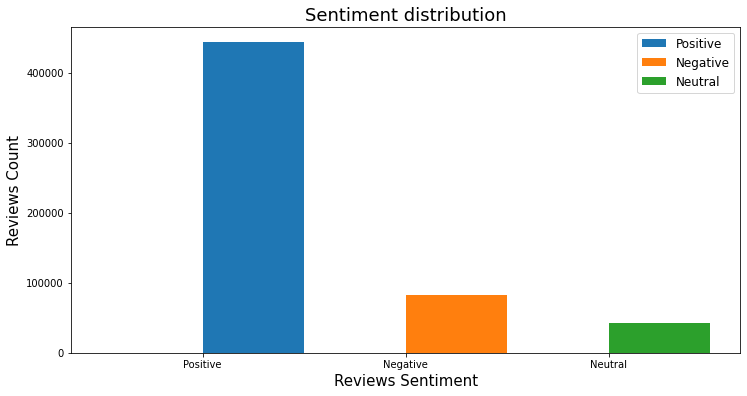

In [10]:
fig = plt.figure(figsize=(12,6))
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Positive'], label='Positive', width=0.5)
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Negative'], label='Negative', width=0.5)
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Neutral'],  label='Neutral', width=0.5)

plt.xlabel("Reviews Sentiment", fontsize=15)
plt.ylabel("Reviews Count", fontsize=15)
plt.title("Sentiment distribution", fontsize=18)
plt.legend(fontsize=12)

plt.show()
fig.savefig('Images/Sentiment_distribution.png', dpi=600)

In [11]:
data["Sentiment"].value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

<span style="color:#E74C3C">**From above plot we can see the positive review are way more than Negative and Neutral reviews. Because of that our model will be slightly biased toward positive review**</span>

#### Cleaning Text Class:

In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [13]:
# Importing stopwords to remove from our data
stop_words = set(stopwords.words('english')) 
# Here we are using regular expression library to clean data
def text_cleaner(text,num):
    # Step 1    
    newString = text.lower()
    # Step 2
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    # Step 3
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    # step 4
    newString = re.sub(r"'s\b","",newString)
    # step 5
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    # step 6
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    # step 7
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [14]:
# cleaning text data:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))
data['Text'] = cleaned_text

#### Removing some positive records and too long review to reduce bias in model 

In [36]:
val = data.loc[(data['Text'].str.len()>=7)&(data['Text'].str.len()<=150) & (data["Sentiment"]=='Positive')]
print(f"Length :{len(val)}")
# val["Sentiment"].value_counts()
val[:5]

Length :195952


,level_0,index,Score,Summary,Text,Sentiment
4,4,4,5,Great taffy,great taffy great price wide assortment yummy ...,Positive
7,7,7,5,"Wonderful, tasty taffy",taffy good soft chewy flavors amazing would de...,Positive
8,8,8,5,Yay Barley,right mostly sprouting cats eat grass love rot...,Positive
9,9,9,5,Healthy Dog Food,healthy dog food good digestion also good smal...,Positive
13,13,13,4,fresh and greasy!,good flavor came securely packed fresh delicio...,Positive


- we have 195952 records with healthy review length
- lets drop records other than this with positive reviews

In [34]:
indexNames = data.loc[((data['Text'].str.len()<=7)|(data['Text'].str.len()>150)) & (data["Sentiment"]=='Positive')].index

# Drpoping rows with summary length less than 2
data.drop(indexNames , inplace=True)
data.head(10)

,level_0,index,Score,Summary,Text,Sentiment
1,1,1,1,Not as Advertised,product arrived labeled jumbo salted peanuts p...,Negative
3,3,3,2,Cough Medicine,looking secret ingredient robitussin believe f...,Negative
4,4,4,5,Great taffy,great taffy great price wide assortment yummy ...,Positive
7,7,7,5,"Wonderful, tasty taffy",taffy good soft chewy flavors amazing would de...,Positive
8,8,8,5,Yay Barley,right mostly sprouting cats eat grass love rot...,Positive
9,9,9,5,Healthy Dog Food,healthy dog food good digestion also good smal...,Positive
12,12,12,1,My Cats Are Not Fans of the New Food,cats happily eating felidae platinum two years...,Negative
13,13,13,4,fresh and greasy!,good flavor came securely packed fresh delicio...,Positive
14,14,14,5,Strawberry Twizzlers - Yummy,strawberry twizzlers guilty pleasure yummy six...,Positive
15,15,15,5,"Lots of twizzlers, just what you expect.",daughter loves twizzlers shipment six pounds r...,Positive


Lets Drop records with review more than 200 charecter length

In [35]:
data["Sentiment"].value_counts()

Positive    195952
Negative     81888
Neutral      42435
Name: Sentiment, dtype: int64

#### VIsualizing data again

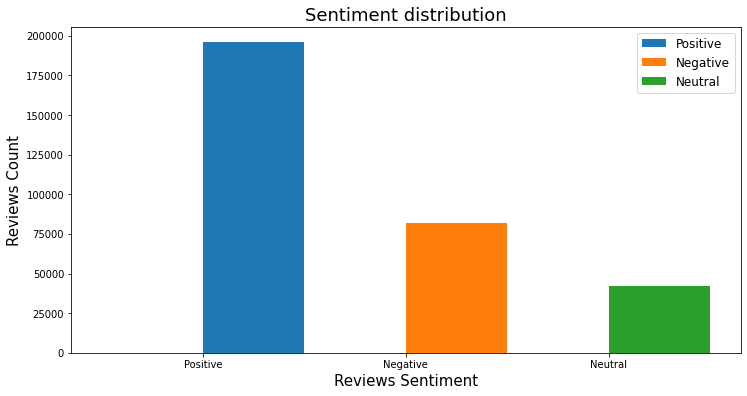

In [37]:
fig = plt.figure(figsize=(12,6))
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Positive'], label='Positive', width=0.5)
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Negative'], label='Negative', width=0.5)
plt.hist(data["Sentiment"].loc[data["Sentiment"]=='Neutral'],  label='Neutral', width=0.5)

plt.xlabel("Reviews Sentiment", fontsize=15)
plt.ylabel("Reviews Count", fontsize=15)
plt.title("Sentiment distribution", fontsize=18)
plt.legend(fontsize=12)

plt.show()
fig.savefig('Images/Sentiment_distribution.png', dpi=600)

Now our records seems more divers and less bias

### Visualization of review summaries:
We are using wordcloud to visualize most common words in reviews

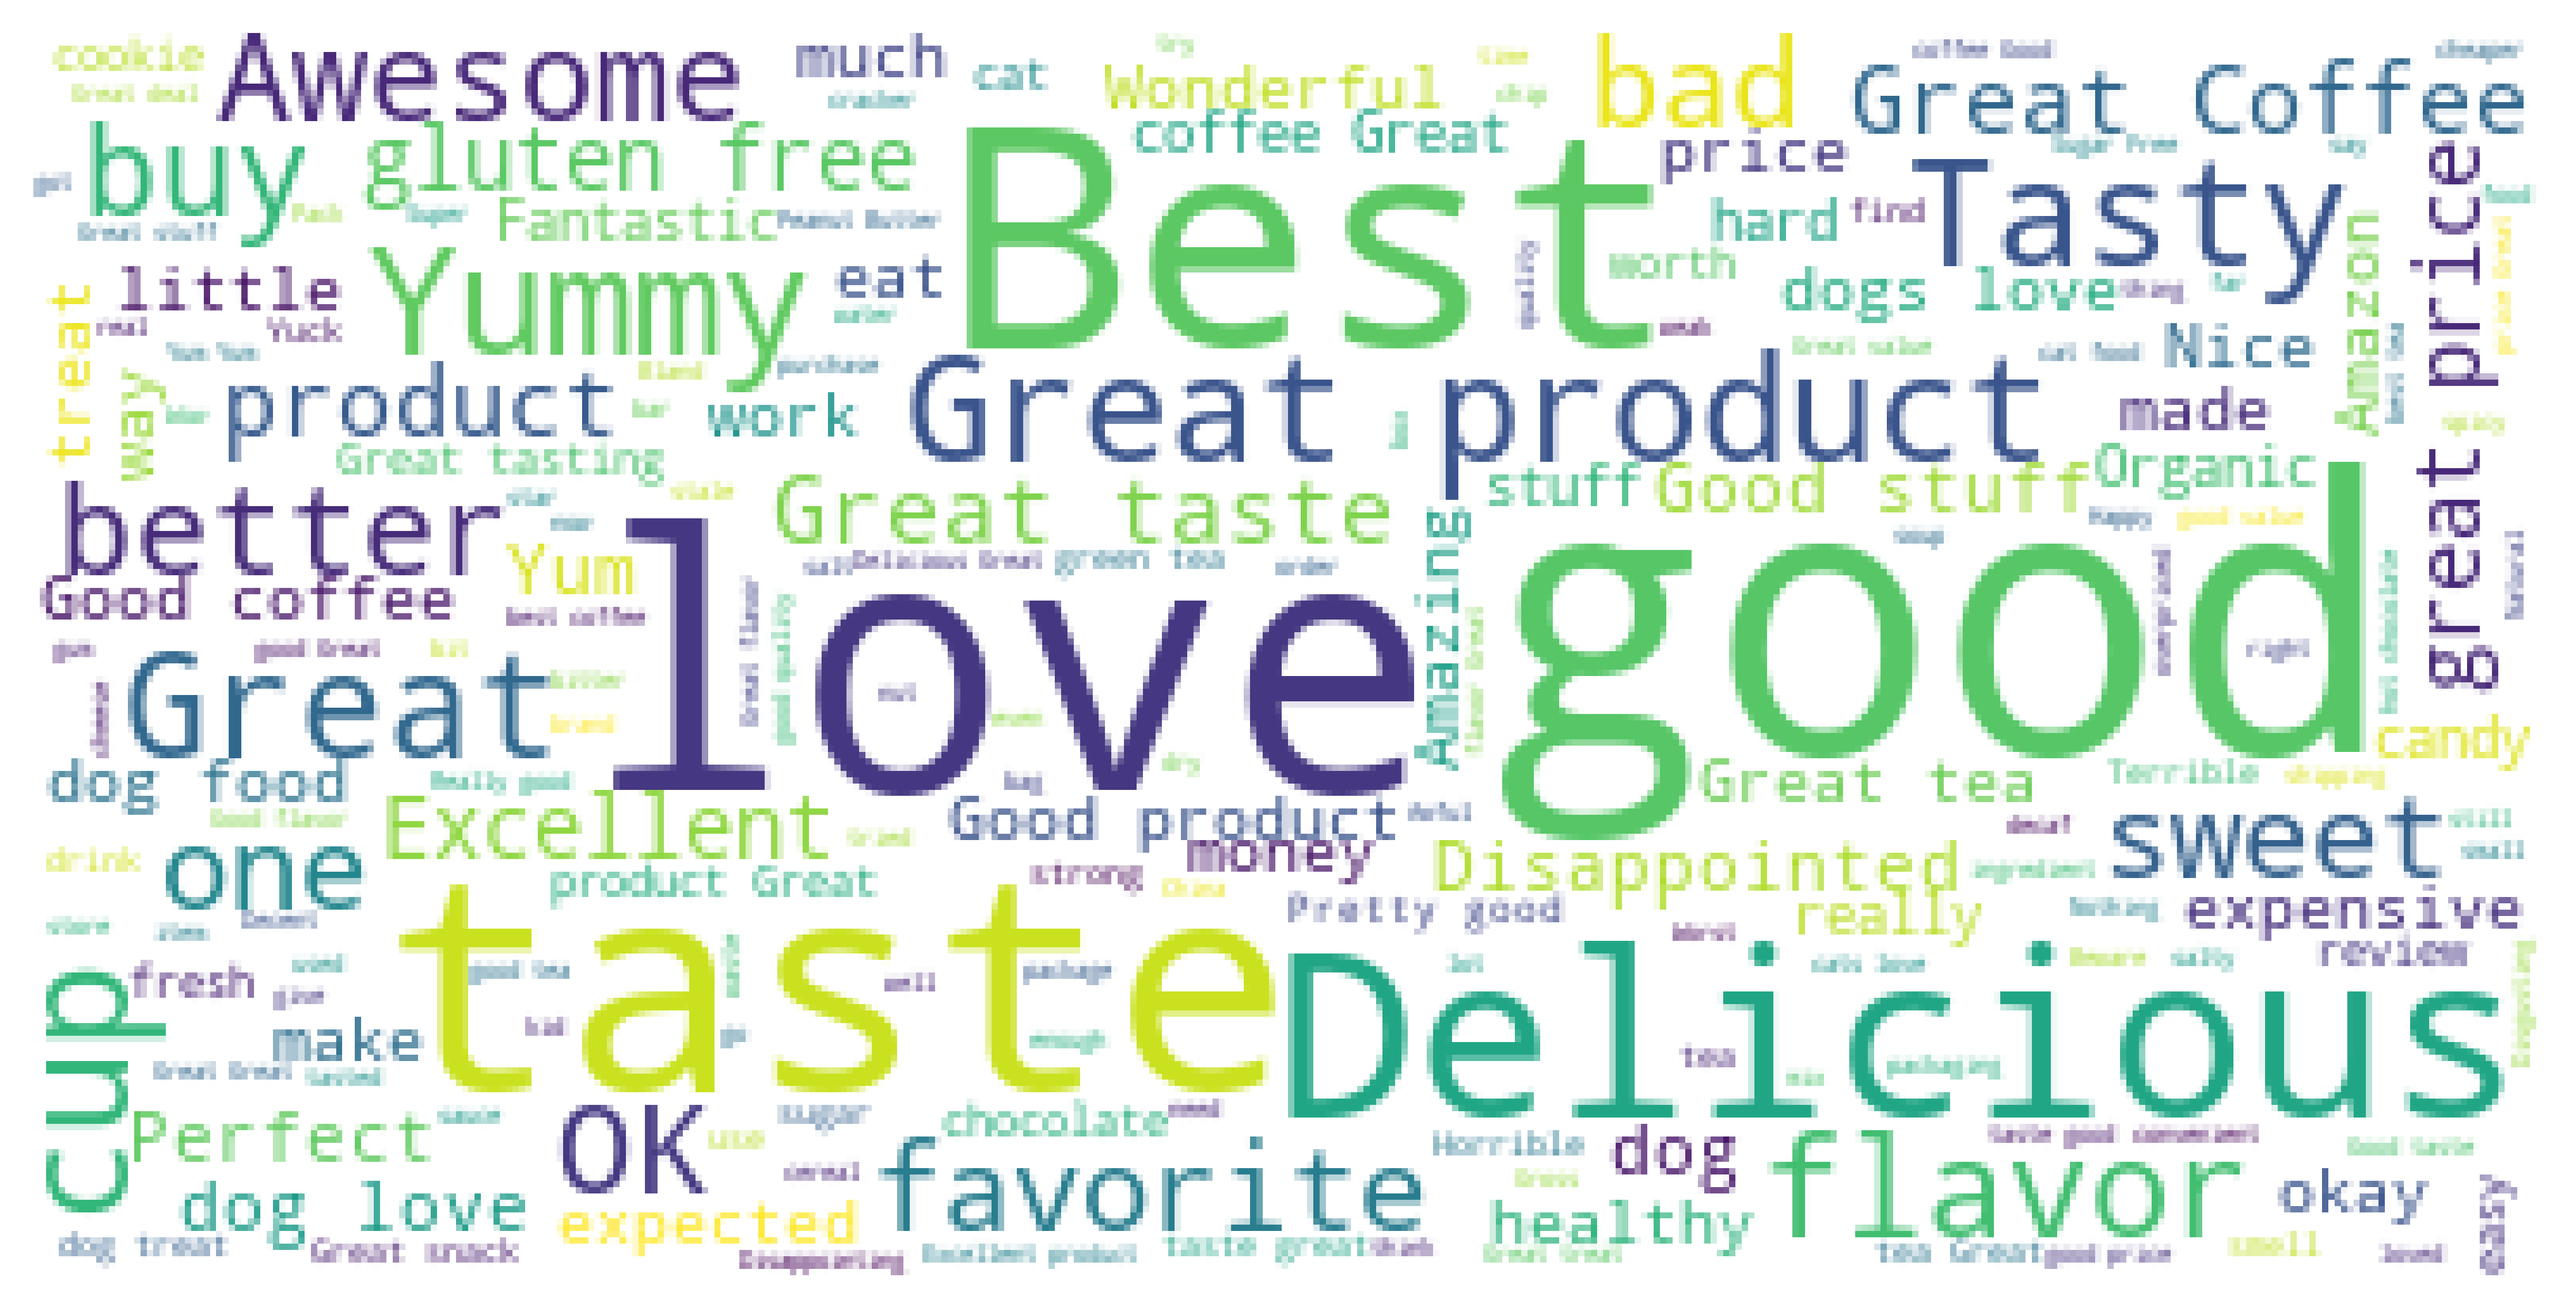

In [40]:
wordcloud2 = WordCloud(background_color='white',max_font_size = 60).generate(' '.join(data['Summary'].astype(str)))
fig = plt.figure(figsize=(12,8), dpi= 600, facecolor='w', edgecolor='k')
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()
fig.savefig('Images/wordcloud.png', dpi=600)

### Split train and test data:
Splitting data into train 80% of data and test 20% of data

In [41]:
X = data["Text"]
y = data["Sentiment"]
X = X.fillna(' ')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Modelling: Model training and predictions

## Build pipelines

### 1. Train and predict function

In [43]:
def train2predict(pipeline):
    start = timeit.timeit()
    print(f"Model Trainig and prediction STARTED @ {start}for :\n{pipeline}\n ")
    pipeline.fit(X_train, y_train)
    predictions_df = pipeline.predict(X_test)
    end = timeit.timeit()
    print(f"Model Trainig and prediction ENDED @ {end}")
    return end-start,predictions_df.copy()

The train2predict function as name suggest train and predict the data:
- `clf`: Model
-  `X_train`: Predictor train data 
-  `y_train`: Target train data
-  `X_test`: Predictor test data

### Model Pipeline

In [44]:
def model_pipeline(ML_model):
    pipeline = Pipeline([("vect", CountVectorizer()),
                         ("tfidf", TfidfTransformer()),
                         ("clf_nominalNB", ML_model)])

    timeSecElapsed, y_pred = train2predict(pipeline)
    return pipeline, timeSecElapsed, y_pred

#### Model pipeline the process of:
1. **`CountVectorizer: Vectorization`**
    <br />Scikit-learn’s CountVectorizer is used to convert a collection of text documents to a vector of term/token counts.
    <br />
    
2. **`TfidfTransformer: (Term Frequency Inverse Documetn frequency)`**
    <br />The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.
    <br />
    
3. **`ML_model:`**  ML Model to be train
    <br />

4. **`Return`**: Function return target variable predictions

### Model performance:

In [45]:
def overall_accuracy(y_pred):
    return str(round(np.mean(y_pred == y_test)*100,2))+' %'

### Visualizing Model Performance:

In [46]:
## Visualization: APIs to plot results
def plot_confusionMatrix(clf, pred, title, cmap, normalize):
    plot_confusion_matrix(clf,X_test,pred,cmap=cmap, normalize=normalize)
    plt.title('Heatmap of confusion matrix (normalized): ' + title)
    plt.show()
    return True

### Model Results:

In [47]:
def results(predicted, model_name):
    print("Overall accuracy of Naive Bayes: " + overall_accuracy(predicted,y_test))
    print("\nResults Report")
    print(classification_report(y_test, predicted))
    
    plot_confusionMatrix(pipeline, X_test, pred=predicted, title=model_name, cmap= plt.cm.Blues,normalize=None)


## 1. Naive Bayes Model:
We will be training data using Naive Bayes Model.

Model Trainig and prediction STARTED @ 0.0071040999996512255for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])
 
Model Trainig and prediction ENDED @ 0.010358099999848491

Multinomial Naive Bayes Execution Time: 0.0032540000001972658

Overall accuracy of Naive Bayes:  78.13 %

Naive Bayes Results Report
              precision    recall  f1-score   support

    Negative       0.77      0.67      0.72     16544
     Neutral       0.82      0.06      0.12      8333
    Positive       0.78      0.98      0.87     39178

    accuracy                           0.78     64055
   macro avg       0.79      0.57      0.57     64055
weighted avg       0.79      0.78      0.73     64055



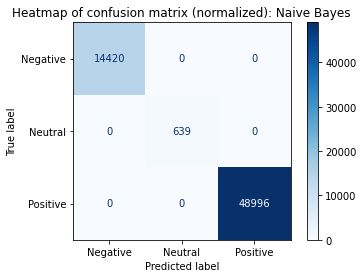

True

In [48]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(MultinomialNB())
print(f"\nMultinomial Naive Bayes Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Naive Bayes: ", overall_accuracy(predicted))

print("\nNaive Bayes Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Naive Bayes', cmap=plt.cm.Blues, normalize=None)

### Testing on own corpus:


In [49]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Negative
Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Neutral
Input: soo taste		   Sentiment: Positive


## 2. Logistic Regression

Model Trainig and prediction STARTED @ 0.006089299999985087for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', LogisticRegression())])
 
Model Trainig and prediction ENDED @ 0.00617869999996401

Logistic Regression Execution Time: 8.9399999978923e-05

Overall accuracy of Logistic Regression:  85.25 %

Logistic Regression Results Report
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80     16544
     Neutral       0.66      0.44      0.53      8333
    Positive       0.90      0.96      0.93     39178

    accuracy                           0.85     64055
   macro avg       0.78      0.74      0.75     64055
weighted avg       0.84      0.85      0.84     64055



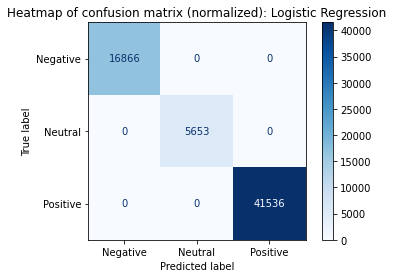

True

In [50]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(LogisticRegression())
print(f"\nLogistic Regression Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Logistic Regression: ", overall_accuracy(predicted))

print("\nLogistic Regression Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Logistic Regression', cmap=plt.cm.Blues, normalize=None)

In [51]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Positive
Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Neutral
Input: soo taste		   Sentiment: Positive


## 3. Linear SVM:

Model Trainig and prediction STARTED @ 0.006312200000138546for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', LinearSVC())])
 
Model Trainig and prediction ENDED @ 0.006282499999997526

Support Vecter Machine Execution Time: -2.97000001410197e-05

Overall accuracy of Support Vecter Machine:  86.54 %

Support Vecter Machine Results Report
              precision    recall  f1-score   support

    Negative       0.81      0.82      0.82     16544
     Neutral       0.71      0.49      0.58      8333
    Positive       0.91      0.96      0.94     39178

    accuracy                           0.87     64055
   macro avg       0.81      0.76      0.78     64055
weighted avg       0.86      0.87      0.86     64055



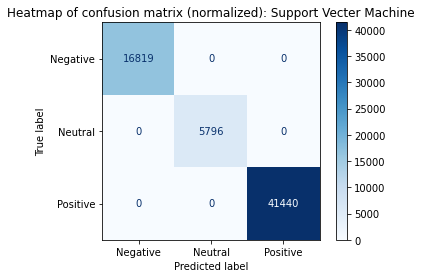

True

In [52]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(LinearSVC())
print(f"\nSupport Vecter Machine Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Support Vecter Machine: ", overall_accuracy(predicted))

print("\nSupport Vecter Machine Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Support Vecter Machine', cmap=plt.cm.Blues, normalize=None)

In [53]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Positive
Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Neutral
Input: soo taste		   Sentiment: Positive


## 4. Decision Tree Classifier:

Model Trainig and prediction STARTED @ 0.0061284000003070105for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', DecisionTreeClassifier(max_depth=150))])
 
Model Trainig and prediction ENDED @ 0.006142899999758811

Decision Tree Classifier Execution Time: 1.449999945180025e-05

Overall accuracy of Decision Tree Classifier:  83.83 %

Decision Tree Classifier Results Report
              precision    recall  f1-score   support

    Negative       0.77      0.74      0.75     16544
     Neutral       0.64      0.56      0.59      8333
    Positive       0.90      0.94      0.92     39178

    accuracy                           0.84     64055
   macro avg       0.77      0.75      0.76     64055
weighted avg       0.83      0.84      0.83     64055



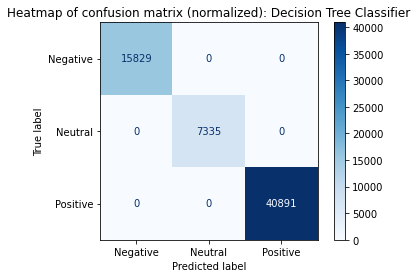

True

In [60]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(DecisionTreeClassifier(max_depth=150))
print(f"\nDecision Tree Classifier Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Decision Tree Classifier: ", overall_accuracy(predicted))

print("\nDecision Tree Classifier Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Decision Tree Classifier', cmap=plt.cm.Blues, normalize=None)

In [61]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Positive
Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Positive
Input: soo taste		   Sentiment: Positive


## 5. Random Forest Classifier:

Model Trainig and prediction STARTED @ 0.00803619999987859for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB',
                 RandomForestClassifier(n_estimators=500, n_jobs=12,
                                        verbose=1))])
 


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 46.1min
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 53.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.4s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    9.8s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:   11.2s finished


Model Trainig and prediction ENDED @ 0.012276900000870228

Random Forest Classifier Execution Time: 0.004240700000991637

Overall accuracy of Random Forest Classifier:  87.29 %

Random Forest Classifier Results Report
              precision    recall  f1-score   support

    Negative       0.82      0.81      0.82     16544
     Neutral       0.99      0.41      0.58      8333
    Positive       0.88      1.00      0.94     39178

    accuracy                           0.87     64055
   macro avg       0.90      0.74      0.78     64055
weighted avg       0.88      0.87      0.86     64055



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    9.5s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:   11.1s finished


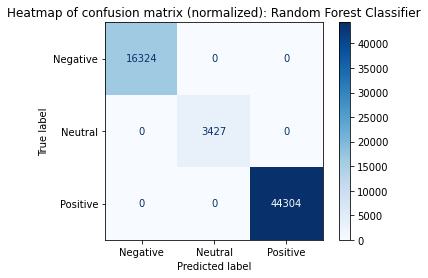

True

In [66]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(RandomForestClassifier(n_estimators =500, n_jobs=12, verbose = 1))
print(f"\nRandom Forest Classifier Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Random Forest Classifier: ", overall_accuracy(predicted))

print("\nRandom Forest Classifier Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Random Forest Classifier', cmap=plt.cm.Blues, normalize=None)

In [67]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s


Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Positive


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s


Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Positive
Input: soo taste		   Sentiment: Positive


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.0s finished


## Multi Layer Perceptron

Model Trainig and prediction STARTED @ 0.006017900001097587for :
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=(3,),
                               learning_rate='adaptive', max_iter=100,
                               verbose=True))])
 
Iteration 1, loss = 0.63111855
Validation score: 0.810905
Iteration 2, loss = 0.45244262
Validation score: 0.817344
Iteration 3, loss = 0.40225699
Validation score: 0.844938
Iteration 4, loss = 0.35225217
Validation score: 0.857154
Iteration 5, loss = 0.32135615
Validation score: 0.861369
Iteration 6, loss = 0.30068290
Validation score: 0.863243
Iteration 7, loss = 0.28447679
Validation score: 0.864921
Iteration 8, loss = 0.27118695
Validation score: 0.865272
Iteration 9, loss = 0.26016012
Validation score: 0.865077
Iteration 10, loss = 0.25093292
Validation score: 0.865

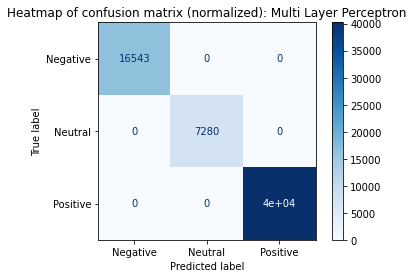

True

In [68]:
# Naive Bayes model
pipeline, timeSecElapsed, predicted = model_pipeline(MLPClassifier(max_iter= 100,
                                                                   activation='tanh',
                                                                   hidden_layer_sizes=(3, ),
                                                                   learning_rate='adaptive', 
                                                                   early_stopping=True,
                                                                   verbose=True, 
                                                                ))
print(f"\nMulti Layer Perceptron Execution Time: {timeSecElapsed}")
print("\nOverall accuracy of Multi Layer Perceptron: ", overall_accuracy(predicted))

print("\nMulti Layer Perceptron Results Report")
print(classification_report(y_test, predicted))

## Visualization: Plot confusion matrices
plot_confusionMatrix(pipeline, pred= predicted, title='Multi Layer Perceptron', cmap=plt.cm.Blues, normalize=None)

In [69]:
test_corpus = ["Highly recomend this product", "taste like shit", "good product", "okay product", "soo taste"]
for corp in test_corpus:
    print(f"Input: {corp}\t\t   Sentiment: {pipeline.predict([corp])[0]}")

Input: Highly recomend this product		   Sentiment: Positive
Input: taste like shit		   Sentiment: Negative
Input: good product		   Sentiment: Positive
Input: okay product		   Sentiment: Neutral
Input: soo taste		   Sentiment: Positive


## Conclusion:
#### We have successfully implemented sentient analysis using:
| Model                       | Accuracy    | Test Performance|
| :---                        | :----       |  :----          |
| 1. Multinomial Naive Bayes  | 78.13 %     | Good on standard corpus |
| 2. Logistic Regression      | 85.25 %     | Okay                |
| 3. Support Vector Machine   | 86.54 %     | Good                |
| 4. Decision Tree Classifier | 83.83 %     | Poor-Overfitting while training |
| 5. Random Forest Classifier | 87.29 %     | Poor-Overfitting,Too long to train |
| 6. Multi Layer Perceptron   | 86.29 %     | Excellent                |

